# 分布の歪みに対する検知をpanderaで実演するnotebook

TFDVのtutorialのサンプルデータを利用して、TFDVの分布の歪み/変化(distribution skew)検知するアルゴリズムをpanderaで模倣します

### 想定されるシチュエーション

- モデルをデプロイし、再学習するにあたり、特徴量の分布が変化してくる

In [111]:
import os
import pandas as pd
import tempfile, urllib, zipfile

# Set up some globals for our file paths
BASE_DIR = "./"
DATA_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'chicago_taxi_output')
TRAIN_DATA = os.path.join(DATA_DIR, 'train', 'data.csv')
EVAL_DATA = os.path.join(DATA_DIR, 'eval', 'data.csv')
SERVING_DATA = os.path.join(DATA_DIR, 'serving', 'data.csv')

# Download the zip file from GCP and unzip it
zip, headers = urllib.request.urlretrieve('https://storage.googleapis.com/artifacts.tfx-oss-public.appspot.com/datasets/chicago_data.zip')
zipfile.ZipFile(zip).extractall(BASE_DIR)
zipfile.ZipFile(zip).close()

print("Here's what we downloaded:")
!ls -R {os.path.join(BASE_DIR, 'data')}

Here's what we downloaded:
eval    serving train

./data/eval:
data.csv

./data/serving:
data.csv

./data/train:
data.csv


In [112]:
train = pd.read_csv(TRAIN_DATA)
train.head()

test = pd.read_csv(EVAL_DATA)

In [113]:
train.head()

,pickup_community_area,fare,trip_start_month,trip_start_hour,trip_start_day,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,pickup_census_tract,dropoff_census_tract,payment_type,company,trip_seconds,dropoff_community_area,tips
0,22,12.85,3,11,7,1393673400,41.920452,-87.679955,41.877406,-87.621972,0.0,NaN,1.703132e+10,Cash,Taxi Affiliation Services,720,32.0,0.0
1,22,5.45,8,21,7,1439675100,41.920452,-87.679955,41.906771,-87.681025,1.2,NaN,1.703124e+10,Cash,Dispatch Taxi Affiliation,360,24.0,0.0
2,33,0.00,5,10,4,1432118700,41.849247,-87.624135,41.849247,-87.624135,0.0,NaN,1.703184e+10,Cash,Northwest Management LLC,0,33.0,0.0
3,33,11.05,3,15,1,1427037300,41.849247,-87.624135,41.892508,-87.626215,0.0,NaN,1.703108e+10,Cash,Taxi Affiliation Services,900,8.0,0.0
4,33,11.05,5,15,6,1401464700,41.849247,-87.624135,41.892508,-87.626215,3.2,NaN,1.703108e+10,Cash,NaN,960,8.0,0.0



### 数値変数に対する分布の歪み

Tensorflow Data Validationを参考に、数値データに対する分布の歪みを検知するCheck methodを実装しました。

Tensorflow Data Validationでは、「近似イエンセン-シャノン距離」をもとに検知しているので、合わせてみます。

https://github.com/tensorflow/tfx/blob/master/docs/guide/tfdv.md#drift-detection

In [1]:
from typing import Optional
from typing import Dict
# import hypothesis
import pandera.extensions as extensions
import pandera.strategies as st

from scipy.stats import gaussian_kde
from scipy.spatial import distance

import pandera as pa
import numpy as np
import pandas as pd
import seaborn as sns

In [53]:
train["is_train"] = 1
test["is_train"] = 0
total_df = pd.concat([train, test]).reset_index(drop=False)

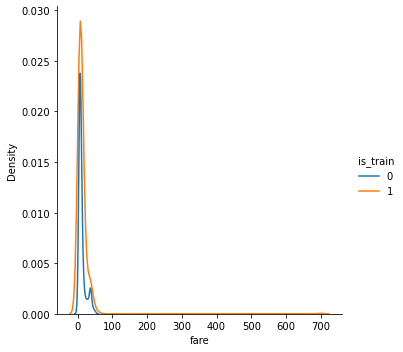

In [79]:
sns.displot(data=total_df.sample(n=1000), x="fare", hue="is_train", kind="kde")

## カスタマイズしたCheck関数の登録方法
- `extensions.register_check_method` decoratorを利用すると、自作したCheckメソッドがpandera.Checkクラスのclassmethodとして呼び出されるようになります
- 

In [2]:
@extensions.register_check_method(
    statistics=["group_train", "group_test"],
    check_type="groupby",
)
def test_js_dist(dict_groups: Dict[str, pd.Series], *, group_train, group_test, threshold=0.2):
    a: pd.Series = dict_groups[group_train]
    b: pd.Series = dict_groups[group_test]
    # 定義域の設定
    range_x = np.linspace(
        start=min(a.min(), b.min()), 
        stop=max(a.max(), b.max()), num=500
    )
    # 対象変数に関して、密度関数をkernel密度推定します
    a_pdf = gaussian_kde(a)
    b_pdf = gaussian_kde(b)
    # 2つの分布の距離を計算して
    stat = distance.jensenshannon(a_pdf(range_x), b_pdf(range_x), 2.0)
    print("Jensen-Shannon Distance: ", stat)
    # 閾値以上に距離が大きくなったら、Falseとなり、検知されます。
    return stat <= threshold

    return dict_groups[group_a].mean() > dict_groups[group_b].mean()



In [72]:
from typing import Dict

schema = pa.DataFrameSchema({
    "trip_start_hour": pa.Column(
        int,
        pa.Check.test_js_dist(group_train=1, 
                              group_test=0, 
                              threshold=0.01 ,
                              groupby="is_train", error="Jensen距離の意味で分布が異なっているようです。"),
    ),
    "is_train": pa.Column(int),
})

try:
    schema(total_df, lazy=True)
    # inferred_schema.validate(test, lazy=True)
except pa.errors.SchemaErrors as err:
    print(err)


Jensen-Shannon Distance:  0.015027889345758624
A total of 1 schema errors were found.

Error Counts
------------
- schema_component_check: 1

Schema Error Summary
--------------------
                                                          failure_cases  n_failure_cases
schema_context column          check                                                    
Column         trip_start_hour Jensen距離の意味で分布が異なっているようです。       [False]                1

Usage Tip
---------

Directly inspect all errors by catching the exception:

```
try:
    schema.validate(dataframe, lazy=True)
except SchemaErrors as err:
    err.failure_cases  # dataframe of schema errors
    err.data  # invalid dataframe
```



In [67]:
sample_data = pd.DataFrame({
    "values": [1, 1, 1, 1, 2, 1, 20, 10, 1, 15],
    "is_train": [0] * 5 + [1] * 5,
    
})


schema = pa.DataFrameSchema({
    "values": pa.Column(
        int,
        pa.Check.test_js_dist(group_train=1, group_test=0, groupby="is_train", error="Jensen距離の意味で分布が異なっているようです。"),
    ),
    "is_train": pa.Column(int),
})

try:
    schema(sample_data, lazy=True)
    # inferred_schema.validate(test, lazy=True)
except pa.errors.SchemaErrors as err:
    print(err)


Jensen-Shannon Distance:  0.8889696575267366
A total of 1 schema errors were found.

Error Counts
------------
- schema_component_check: 1

Schema Error Summary
--------------------
                                                 failure_cases  n_failure_cases
schema_context column check                                                    
Column         values Jensen距離の意味で分布が異なっているようです。       [False]                1

Usage Tip
---------

Directly inspect all errors by catching the exception:

```
try:
    schema.validate(dataframe, lazy=True)
except SchemaErrors as err:
    err.failure_cases  # dataframe of schema errors
    err.data  # invalid dataframe
```



実際にデータ見てみると、、

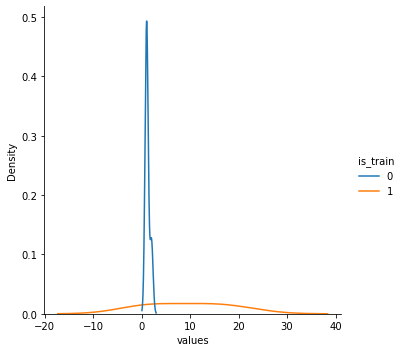

In [75]:
sns.displot(data=data, x="values", hue="is_train", kind="kde")

変なデータがtestデータに入っているのがわかりました！

### カテゴリ変数に対する分布の歪み

同じく、Tensorflow Data Validationを参考に、カテゴリデータに対する分布の歪みを検知するCheck methodを実装しました。

Tensorflow Data Validationでは、「L-infinity distance」をもとに検知しているので、合わせてみます。

`L-infinity distance`と言いますが、要は同じカテゴリの割合の差分の絶対値の最大値を計算しています。

- $\displaystyle \max_i |x_i - y_i|$


In [29]:
pd.concat(
    [train["payment_type"].value_counts(normalize=True), 
     test["payment_type"].value_counts(normalize=True)], axis=1)

,hoge,payment_type
Cash,0.6590,0.6638
Credit Card,0.3325,0.3298
No Charge,0.0060,0.0042
Unknown,0.0022,0.0012
Pcard,0.0002,0.0002
Dispute,0.0001,0.0006
Prcard,NaN,0.0002


In [36]:
# かなりコード汚いですが、各カテゴリがどれくらいデータセットに含まれているかの割合の差分を計算しています。
train["payment_type"].value_counts(normalize=True) - test["payment_type"].value_counts(normalize=True)

Cash          -0.0048
Credit Card    0.0027
Dispute       -0.0005
No Charge      0.0018
Pcard          0.0000
Prcard            NaN
Unknown        0.0010
dtype: float64

In [37]:
# L-infinity distance
max(abs(train["payment_type"].value_counts(normalize=True) - test["payment_type"].value_counts(normalize=True)))

0.0047999999999999154

上記の実装を踏まえて、カテゴリ変数の分布のskewをカスタムCheckしてみます。

In [46]:

@extensions.register_check_method(
    statistics=["group_train", "group_test"],
    check_type="groupby",
)
def check_L_inf_distance(dict_groups: Dict[str, pd.Series], *, group_train, group_test, threshold=0.2):

    train: pd.Series = dict_groups[group_train]
    test: pd.Series = dict_groups[group_test]
    abs_value_diff: pd.Series = train.value_counts(normalize=True) - test.value_counts(normalize=True)
    dist = abs_value_diff.abs().max()
    print("L-infinity distance: ", dist)
    # 閾値以上に距離が大きくなったら、Falseとなり、検知されます。
    return dist <= threshold




In [47]:
schema = pa.DataFrameSchema({
    "payment_type": pa.Column(
        str,
        pa.Check.check_L_inf_distance(
            group_train=1, group_test=0,
            groupby="is_train",
            error="L-infinity 距離の意味で分布が異なっているようです。"),
    ),
    "is_train": pa.Column(int),
})

try:
    schema(total_df, lazy=True)
except pa.errors.SchemaErrors as err:
    print(err)


L-infinity distance:  0.0047999999999999154


<AxesSubplot:xlabel='payment_type', ylabel='index'>

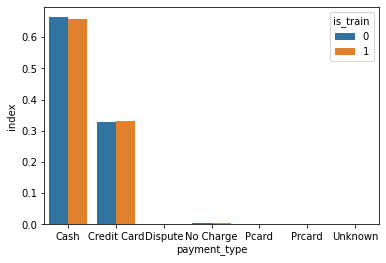

In [102]:
category_share = total_df.groupby(["is_train", "payment_type"]).count().divide(total_df.groupby(["is_train"]).count())["index"]
sns.barplot(
    data=category_share.reset_index(),
    x="payment_type",
    y="index",
    hue="is_train"
)

想定した閾値よりは分布の違いはなさそうなので、検知はされませんでしたね！


### 分布の変化に対しても、TFDV同様に、Validationを検知することができたと思います！

### 結局検知できるかどうかは、設定した閾値次第...

どう設定するのかはほんとに悩ましい問題ですが、本家？のTensorflowも、ここの閾値設定に関して「ドメイン知識を活用しましょう^^」とあるので、golden ruleはないよね、、という話でした。



<AxesSubplot:xlabel='type', ylabel='share'>

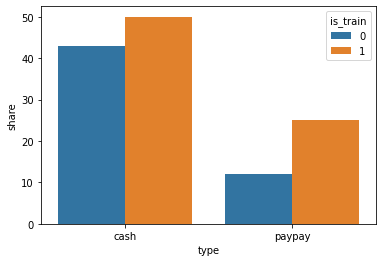

In [109]:
train = pd.DataFrame({"type":["cash", "paypay"], "share":[50, 25], "is_train":[1, 1]})
test = pd.DataFrame({"type":["cash", "paypay"], "share":[43, 12], "is_train":[0, 0]})

sns.barplot(
    data=pd.concat([train, test], axis=0),
    x="type",
    y="share",
    hue="is_train"
)
